<h1 style="text-align:center">Advanced Statistical Inference</h1>
<h1 style="text-align:center">Feature selection</h1>

## 1. Aims
<div class="alert alert-info">
To carry out feature selection on the leukaemia data.
</div>

## 2. Feature selection 
<div class="alert alert-info">
On the course webpage, you can download a (slightly reduced) version of the leukaemia data. It consists of some training data $X$ and associated labels $t$ as well as independent test data $X_{test}$ and $t_{test}$. Your task is to select some features and classify the data – in previous labs we have implemented code for classification and you may use whichever you like.
</div>

In [91]:
import pandas as pd
import numpy as np
import scipy.io
leuk = scipy.io.loadmat('labdata.mat')

In [2]:
X = leuk['X']
t = leuk['t']
X_test = leuk['X_test']
t_test = leuk['t_test']

In [3]:
X_test.shape

(34, 300)

<div class="alert alert-info">
Observe the class distribution of the data.
</div>

In [3]:
import matplotlib.pyplot as plt

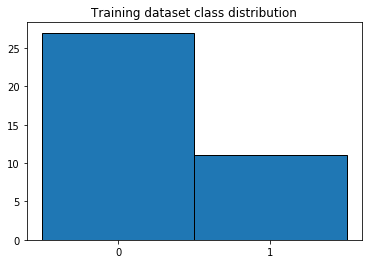

In [8]:
bins = np.arange(3) - 0.5
plt.hist(t, bins,edgecolor='black')
plt.xticks(range(2))
plt.title("Training dataset class distribution")
plt.show()

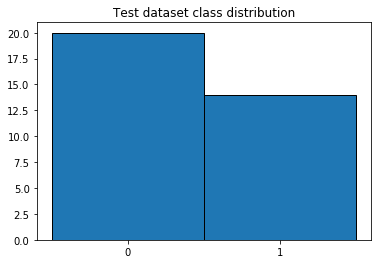

In [7]:
bins = np.arange(3) - 0.5
plt.hist(t_test, bins,edgecolor='black')
plt.xticks(range(2))
plt.title("Test dataset class distribution")
plt.show()

<div class="alert alert-success">
There is a slight imbalance in the classes.</div>

### 2.1 Feature selection 
<div class="alert alert-info">
You are free to use any of the feature selection schemes we covered – scoring the features, PCA, or clustering them (you should already have $k$-means code to do this). In each case, you should use the test set to investigate how performance varies as you change the number of features.</div>

#### 2.1.1 Scoring 
<div class="alert alert-info">
Use the scoring mechanism described in the lectures (only on the training data) to obtain a set of features (corresponding to a subset of the original ones). You should make sure you extract this subset from the test data too!
</div>

In [130]:
def order_features_by_score(X):
    
    scores=[]
    
    
    for i in range(len(X[0])):
        
        class_1=X[np.where(t==1)[0],i]
        class_0=X[np.where(t==0)[0],i]
        
        
        mean_class_1=np.mean(class_1)
        mean_class_0=np.mean(class_0)
        
        var_class_1=np.var(class_1)
        var_class_0=np.var(class_0)
        
        scores.append((np.abs(mean_class_1-mean_class_0)/(var_class_0+var_class_1)))
    
    ordered_features=np.argsort(scores)[::-1]
    
    return ordered_features,scores

In [131]:
ordered_features, scores = order_features_by_score(X)

print("The 10 most important features:")
for i in range(10):
    print("Feature #%d" %ordered_features[i])
    
    

The 10 most important features:
Feature #50
Feature #129
Feature #179
Feature #190
Feature #29
Feature #39
Feature #96
Feature #13
Feature #143
Feature #166


<div class="alert alert-info">
Plot the data by considering the top 2 features and comment on the results.
</div>

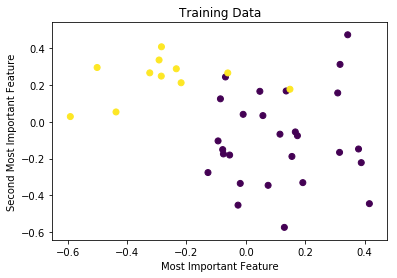

In [13]:
plt.scatter(X[:,ordered_features[0]],X[:,ordered_features[1]],c=t.reshape(-1))
plt.xlabel("Most Important Feature")
plt.ylabel("Second Most Important Feature")
plt.title("Training Data")
plt.show()

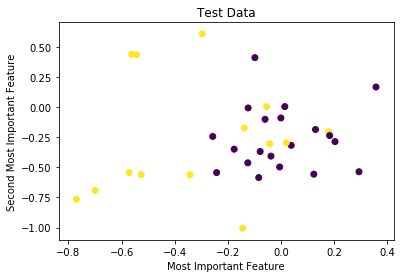

In [14]:
plt.scatter(X_test[:,ordered_features[0]],X_test[:,ordered_features[1]],c=t_test.reshape(-1))
plt.xlabel("Most Important Feature")
plt.ylabel("Second Most Important Feature")
plt.title("Test Data")
plt.show()

<div class="alert alert-info">
Does the visualisation of separate classes improve if you consider the top 3 features instead?</div>

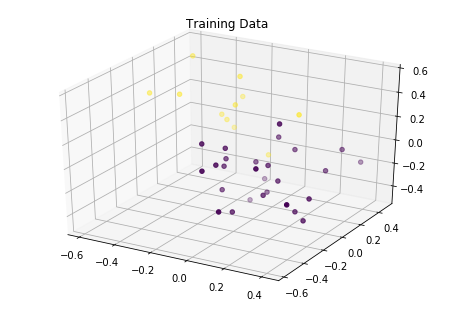

In [15]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(X[:,ordered_features[0]],X[:,ordered_features[1]],X[:,ordered_features[2]],c=t.reshape(-1))
plt.title("Training Data")
plt.show()

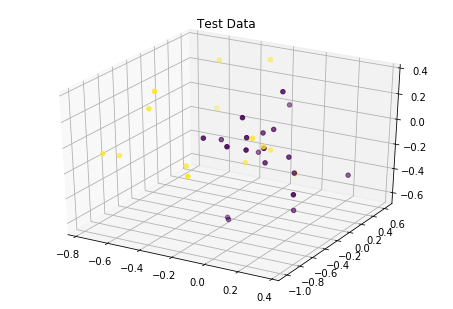

In [16]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(X_test[:,ordered_features[0]],X_test[:,ordered_features[1]],X_test[:,ordered_features[2]],c=t_test.reshape(-1))
plt.title("Test Data")
plt.show()

<div class="alert alert-success">
Yes visualisation improves as they appear separated.</div>

#### 2.1.2 Clustering
<div class="alert alert-info">

You can use the $k$-means code you implemented in the previous notebook. Remember to pass the data the correct way around and only cluster the training data. Transforming the test data is a little more complex – your $k$-means should give you assignments of features to clusters. Use these alongside the test data to compute the cluster means for the test data (you do not need to re-assign the clusterings).

</div>

In [10]:
X.shape

(38, 300)

In [11]:
X_test.shape

(34, 300)

In [4]:
#function for kmeans++
#credits:http://yongsun.me/2008/10/k-means-and-k-means-with-python/

from functools import reduce

def kinit (X, k, ntries=None):  
    'init k seeds according to kmeans++'  
    if not ntries: ntries = int (2 + np.log(k))  
    n = X.shape[0]  
  
    'choose the 1st seed randomly, and store D(x)^2 in D[]'  
    centers = [X[np.random.randint(n)]]  
    D       = [np.linalg.norm(x-centers[0])**2 for x in X]  
    Dsum    = reduce (lambda x,y:x+y, D)  
  
    for _ in range(k-1):  
        bestDsum = bestIdx = -1  
  
        for _ in range(ntries):  
            randVal = np.random.random() * Dsum  
            for i in range(n):  
                if randVal <= D[i]:  
                    break  
                else:  
                    randVal -= D[i]  
  
            'tmpDsum = sum_{x in X} min(D(x)^2,||x-xi||^2)'  
            tmpDsum = reduce(lambda x,y:x+y,  
                             (min(D[j], np.linalg.norm(X[j]-X[i])**2) for j in range(n)))  
  
            if bestDsum < 0 or tmpDsum < bestDsum:  
                bestDsum, bestIdx  = tmpDsum, i  
  
        Dsum = bestDsum  
        centers.append (X[bestIdx])  
        D = [min(D[i], np.linalg.norm(X[i]-X[bestIdx])**2) for i in range(n)]  
  
    return np.array (centers)  



In [5]:
#KMEANS CODE

#HELPER FUNCTIONS



def random_centroids(k,dim):
    cents=[]
    for _ in range(k):
        cent=[]
        for _ in range(dim):
            cent.append(np.random.randint(-3,4))
        cents.append(cent)
        
    return np.array(cents)
    

    
def assignment(X,centroids):
    
    assignments=[]
    distances=[]
    
    for x in X:
        distances.append(np.linalg.norm(x-centroids,axis=1))
    
    assignments=np.argmin(distances,axis=1)
    
    return assignments


def update(assignments,X,k):
    
    cents=[]
    
    for i in range(k):
        
        closest_points=np.where(assignments==i)
        if(len(closest_points[0])==0):
            cents.append(random_centroids(1,dim=X.shape[1])[0])
            
        else:
            cents.append(np.mean(X[closest_points],axis=0))
    
    return cents
    
    
    
    
def kmeans(data, k, centroids=None):
    
    if(centroids is None):
        centroids=random_centroids(k,data.shape[1])
    i=1
    
    while(1):
        assignments=assignment(data,centroids)
        updated_cents=update(assignments,data,k)
        
        if(np.array_equal(updated_cents,centroids)):
            #rint("Finished in %d iterations." %i)
            return updated_cents,assignments
        
        centroids=updated_cents
        #rint(centroids)
        i+=1
            
        

In [12]:
centroids,_=kmeans(X.T,8,centroids=kinit(X.T,8))

In [13]:
centroids=np.array(centroids)

In [14]:
centroids.shape

(8, 38)

In [19]:
assignments=assignment(X.T,centroids)

In [20]:
assignments

array([2, 0, 4, 2, 7, 7, 3, 0, 3, 2, 4, 0, 7, 3, 0, 3, 3, 4, 7, 0, 1, 6,
       7, 1, 0, 6, 7, 7, 1, 1, 0, 1, 3, 1, 5, 1, 1, 0, 5, 3, 7, 3, 7, 7,
       4, 0, 3, 3, 0, 7, 1, 4, 7, 4, 1, 7, 3, 7, 4, 2, 7, 3, 1, 5, 7, 4,
       2, 3, 7, 3, 0, 1, 0, 7, 1, 4, 7, 1, 2, 1, 1, 6, 1, 1, 1, 1, 6, 5,
       5, 4, 1, 1, 6, 3, 7, 0, 1, 3, 1, 6, 6, 3, 2, 3, 4, 7, 1, 0, 7, 3,
       1, 1, 3, 3, 7, 1, 1, 0, 2, 1, 1, 1, 3, 1, 3, 4, 4, 1, 0, 3, 4, 1,
       1, 0, 3, 1, 4, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 4, 3, 0, 1,
       6, 7, 1, 2, 1, 7, 6, 4, 1, 1, 3, 1, 1, 1, 3, 6, 1, 3, 1, 4, 1, 6,
       3, 1, 1, 3, 3, 7, 4, 1, 1, 4, 0, 3, 0, 4, 3, 1, 1, 3, 7, 3, 1, 3,
       1, 1, 3, 4, 4, 1, 7, 6, 1, 3, 3, 3, 1, 7, 3, 1, 3, 1, 3, 7, 3, 3,
       1, 1, 4, 1, 3, 3, 3, 3, 3, 1, 1, 1, 7, 3, 3, 1, 3, 1, 3, 1, 0, 6,
       1, 7, 1, 1, 7, 3, 1, 3, 4, 3, 1, 1, 4, 1, 1, 1, 1, 3, 4, 3, 1, 1,
       2, 1, 3, 6, 1, 1, 1, 1, 3, 1, 3, 1, 7, 1, 1, 4, 1, 7, 1, 1, 1, 1,
       0, 1, 7, 3, 3, 0, 3, 4, 3, 7, 1, 4, 3, 7], d

In [88]:
k=8
X_test_new=np.zeros([X_test.shape[0],k])
for i in range(k):
        features=np.where(assignments==i)
        X_test_new[:,i]=np.mean(X_test[:,features].reshape(X_test.shape[0],len(features[0])),axis=1)
    

In [89]:
X_test_new.shape

(34, 8)

#### 2.1.3 Principal components
<div class="alert alert-info">
Implement a function for obtaining the $k$ principal components of your data.
Try to avoid using 'sklearn' libraries for this task!
</div>

In [313]:
np.linalg.eig(np.cov(X.T))[1].shape

(300, 300)

In [124]:
def pca_k(X, k):
    return np.linalg.eig(np.cov(X))[1][:k]

<div class="alert alert-info">
As before, compare and contrast the effectiveness of using PCA when considering 2 and 3 principal components, respectively.<br>
Plot your results using scatter plots and comment on what you observe.
</div>

In [321]:
eigen_vectors=pca_k(X,2)

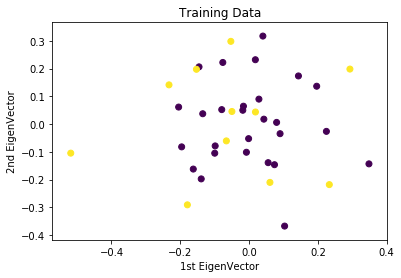

In [322]:
plt.scatter(eigen_vectors[0],eigen_vectors[1],c=t.reshape(-1))
plt.xlabel("1st EigenVector")
plt.ylabel("2nd EigenVector")
plt.title("Training Data")
plt.show()

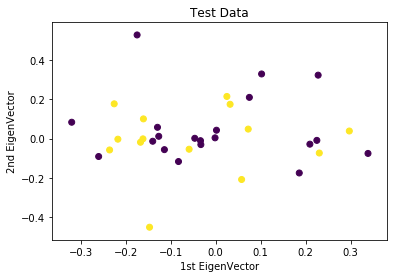

In [149]:
eigen_vectors=pca_k(X_test,2)
plt.scatter(eigen_vectors[0],eigen_vectors[1],c=t_test.reshape(-1))
plt.xlabel("1st EigenVector")
plt.ylabel("2nd EigenVector")
plt.title("Test Data")
plt.show()

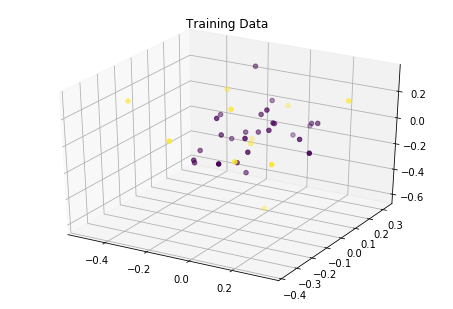

In [150]:

eigen_vectors=pca_k(X,3)
fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(eigen_vectors[0],eigen_vectors[1],eigen_vectors[2],c=t.reshape(-1))
plt.title("Training Data")
plt.show()

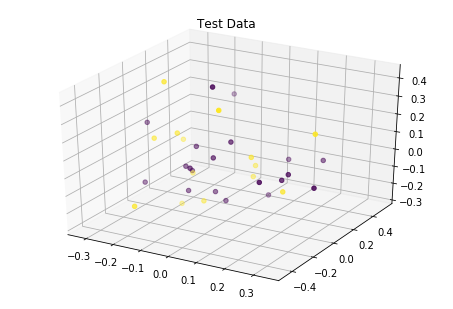

In [151]:
eigen_vectors=pca_k(X_test,3)


fig = plt.figure()
ax = Axes3D(fig)


ax.scatter(eigen_vectors[0],eigen_vectors[1],eigen_vectors[2],c=t_test.reshape(-1))
plt.title("Test Data")
plt.show()

<div class="alert alert-success">
The results seem worse compared to the scoring method we did before. It looks like we need more eigen vectors to better separate the data.
</div>

## 3. Classification
<div class="alert alert-info">
Insofar, we have only considered how carrying out dimensionality reduction allows us to _visually_ distinguish the different classes of the dataset.<br><br>

Using any of the classification algorithms we developed in the previous lectures, assess how classification performance varies when carrying out any of the above feature selection techniques as a preprocessing step. </div>

In [104]:
class Naive_Bayesian_Classifier:
    
    def __init__(self,priors=None):
        
        #arrays for storing mean and std of each feature
        self.means=[]
        self.vars=[]
        #variable to store number of classes
        self.n_classes=0
        
        
        #list for storing log of the likelihood
        self.log_lklhd=[]
        
        
        
        self.priors=None
        
        #assign prior
        if(priors is not None):
            self.priors=priors
    
        
    def fit(self,X,y):
        
        '''fit the data to the model'''
        
        #get number of classes
        #we use set() to get distinct classes
        self.n_classes=len(np.unique(y))                              
                
        
        for k in range(self.n_classes):    
            
            #find rows with a specific label
            filtered_data=X[y==k]
            
            #calculate mean and variance of each feature of the filtered data
            self.means.append(np.mean(filtered_data,axis=0)) 
            self.vars.append(np.var(filtered_data,axis=0))
        
        
        #credits goes to :https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/naive_bayes.py#L341
        #remove zero variances
        # If the ratio of data variance between dimensions is too small, it
        # will cause numerical errors. To address this, we artificially
        # boost the variance by epsilon, a small fraction of the standard
        # deviation of the largest dimension.
        epsilon = 1e-9 * np.var(X, axis=0).max()
        self.vars=np.array(self.vars)
        self.vars+= epsilon
            
         
        #compute prior if not given
        if(self.priors is None):    
            self.priors=np.array([X[y==k].shape[0] for k in range(self.n_classes)])
            self.priors=self.priors/sum(self.priors)
        
        
    def predict(self,X_test):
        
        '''predict class of test data'''
        
        pred=[]

        self.means=np.array(self.means)

        #calculate pdf
        #compute log_likelihood of each class
        for i in range(self.n_classes):
             
            #calculate left and right part of the equation above
            left_part=-np.sum((X_test-self.means[i])**2/(2*self.vars[i]),axis=1)
            right_part=np.array([-0.5*np.sum(np.log(2*np.pi*self.vars[i]))])
            
            #add together
            self.log_lklhd.append((left_part+right_part))

        self.log_lklhd=np.transpose(self.log_lklhd)+np.log(self.priors)
        pred=np.argmax(self.log_lklhd,axis=1)
        return pred
    

    
    def log_prob(self):  
        '''returns the logarithm of the probabilities'''
        
        total=logsumexp(self.log_lklhd,axis=1)
        return (self.log_lklhd-np.atleast_2d(total).T)
    
    def prob(self):
        '''returns the proabilities of test data belonging to the different classes'''
        return np.exp(self.log_prob())
    
    
    def log_likelihood(self):
        '''return log_likelihood'''
        return self.log_lklhd
    
    def accuracy(self,y_true,y_pred):
        
        
        n_misses=np.sum(np.array(y_true)!=np.array(y_pred))
        acc=(1-n_misses/len(y_true))
        return acc

<div class="alert alert-info">
<strong>Without Any Preprocessing</strong>
</div>

In [125]:
acc=0
NBC=Naive_Bayesian_Classifier()
data=pd.DataFrame(X)
NBC.fit(data,t)
y_pred=NBC.predict(X_test)
acc=(NBC.accuracy(np.squeeze(t_test),y_pred))

In [126]:
acc

0.9117647058823529

<div class="alert alert-info">
<strong>Scoring</strong>
</div>

In [132]:
acc=[]
for k in range(1,X.shape[1]+1):
    NBC=Naive_Bayesian_Classifier()
    data=pd.DataFrame(X[:,ordered_features[0:k]])
    NBC.fit(data,t)
    y_pred=NBC.predict(X_test[:,ordered_features[0:k]])
    acc.append(NBC.accuracy(np.squeeze(t_test),y_pred))

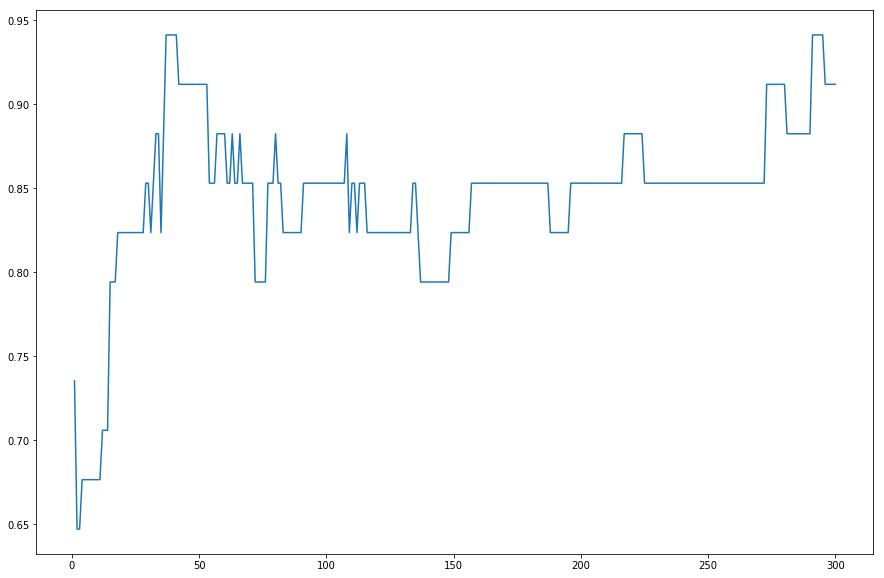

In [133]:
plt.figure(figsize=(15,10))
plt.plot(range(1,X.shape[1]+1),acc)
plt.show()

In [134]:
np.max(acc)

0.9411764705882353

In [135]:
np.argmax(acc)+1

37

<div class="alert alert-success">
The highest accuracy we got on the test data was with 37 features.</div>

<div class="alert alert-info">
<strong>Clustering</strong>
</div>

In [144]:
acc=[]
for k in range(1,X.shape[1]):
    centroids,_=kmeans(X.T,k,centroids=kinit(X.T,k))
    assignments=assignment(X.T,centroids)
    
    X_train_new=np.zeros([X.shape[0],k])
    for i in range(k):
        features=np.where(assignments==i)
        X_train_new[:,i]=np.mean(X[:,features].reshape(X.shape[0],len(features[0])),axis=1)
        
        
    X_test_new=np.zeros([X_test.shape[0],k])
    for i in range(k):
        features=np.where(assignments==i)
        X_test_new[:,i]=np.mean(X_test[:,features].reshape(X_test.shape[0],len(features[0])),axis=1)
        
        
        
    NBC=Naive_Bayesian_Classifier()
    data=pd.DataFrame(X_train_new)
    NBC.fit(data,t)
    y_pred=NBC.predict(X_test_new)
    acc.append(NBC.accuracy(np.squeeze(t_test),y_pred))
    
    

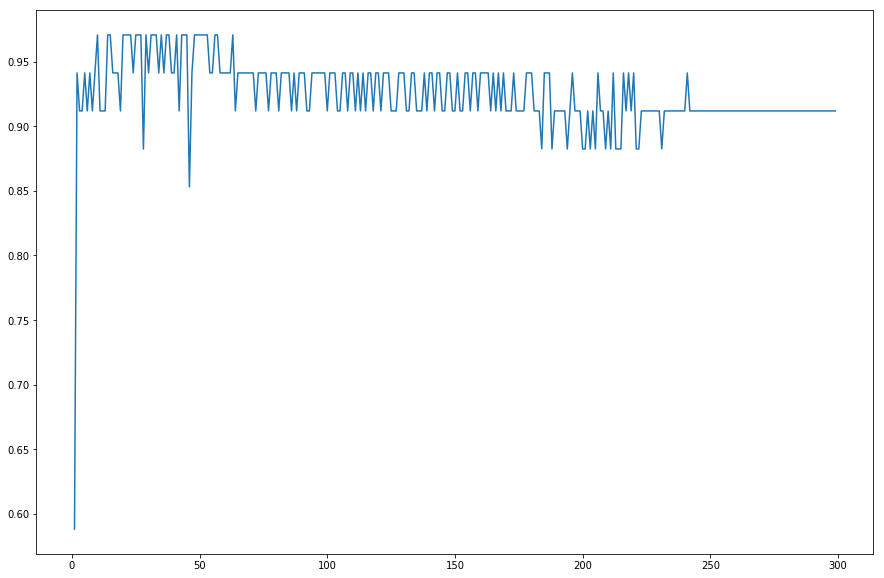

In [145]:
plt.figure(figsize=(15,10))
plt.plot(range(1,X.shape[1]),acc)
plt.show()

In [146]:
np.max(acc)

0.9705882352941176

In [147]:
np.argmax(acc)+1

10

<div class="alert alert-success">
The highest accuracy we got on the test data was with 10 features.</div>

<div class="alert alert-info">
<strong>PCA</strong>
</div>

In [140]:
acc=[]
for k in range(1,X.shape[1]+1):
    NBC=Naive_Bayesian_Classifier()
    W=np.real(pca_k(X.T,k).T)
    data=pd.DataFrame(np.dot(X,W))
    NBC.fit(data,t)
    y_pred=NBC.predict(np.dot(X_test,W))
    acc.append(NBC.accuracy(np.squeeze(t_test),y_pred))

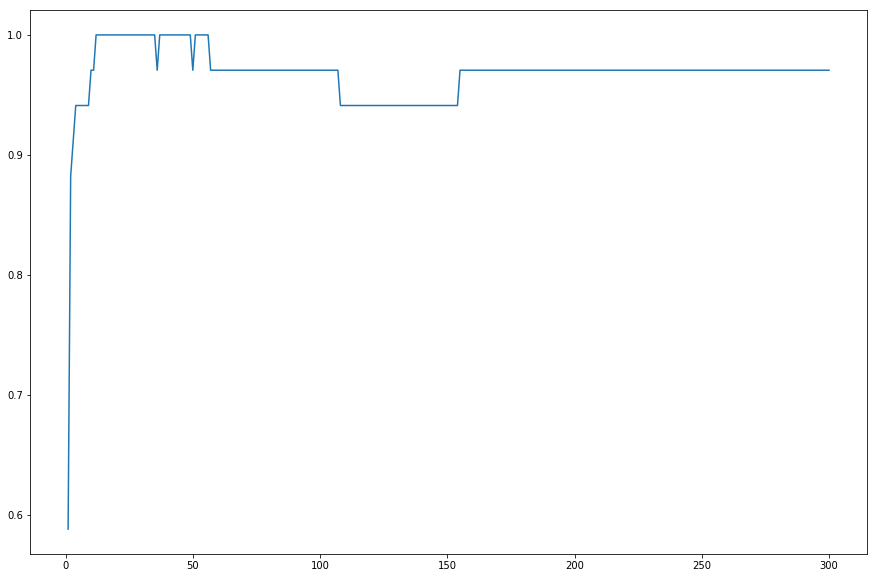

In [141]:
plt.figure(figsize=(15,10))
plt.plot(range(1,X.shape[1]+1),acc)
plt.show()

In [142]:
np.max(acc)

1.0

In [143]:
np.argmax(acc)+1

12

<div class="alert alert-success">
The highest accuracy we got on the test data was with 12 features.</div>